# This notebook implements the coordinated version of FIM gradient descent, so that the sensors minimizes can adapt their step updates to maximize the global FIM in a distributed fashion.

**Also, we only consider fixed-topology networks in the experiments below.**

In [1]:

%matplotlib inline
import numpy as np
from scipy import special
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import pickle as pkl
import networkx as nx
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter,joint_meas_func
from utils.FIMPathPlanning import FIM_descent_path_planning 
from utils.dLdp import analytic_FIM,analytic_dLdp,analytic_dhdz,analytic_dhdq
from utils.regions import CircleExterior
from utils.ConsensusEKF import ConsensusEKF
from tracking_log import logger



%load_ext autoreload
%autoreload 2

## Set up F_tilde data structure

In [2]:
def circulant(i,q,p,prev,post,undirected=False):
    """
        Generate a circulant graph with len(p) nodes, node i connected with [i-prev:i+post],i-prev and i+post included but self-loop eliminated.
    """
    n = len(p)
    G = nx.DiGraph()
    edges = [(j%n,i) for i in range(n) for j in range(i-prev,i+post+1)]
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))
    if undirected:
        G = G.to_undirected()
    return G
    

In [8]:
def main(initial_locs,comm_network_generator,N_iter,C_gain,F_gain,coordinate=False):
    """
    Note: 
    comm_network_generator(i,qs,ps) is the expected signature of the second argument.

        Given the iteration number i, source location qs, sensor location ps,
        comm_network_generator return the current communication network G.
    
    C_main is the gain for ConsensusEKF
    
    F_gain is the gain for global FIM consensus.
    """
    # Set up mobile sensors and sources
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]

    src_locs = [[20.,20]]
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    # Set up virtual sensors
    C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
    C0=0
    k=1
    b=-2
    std = 0.1
    vs = virtual_sensor(C1,C0,b,k,std)

    # Set up location estimator
    n_sen = len(mobile_sensors)
    n_src = len(source)

    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = k * np.ones(n_sen)
    bs = b*np.ones(n_sen)

    q_0 = np.random.rand(len(mobile_sensors),2)*10
    estimators = [ConsensusEKF(q,C_gain=C_gain) for q in q_0]

    # Set up data logger
    log = logger(sensor_names,src_names)
    log.est_locs_log =dict({"Est {}".format(sensor):[] for sensor in sensor_names})
    F_est_log = {name:[] for name in sensor_names}
    F_est_log['FIM Glob'] = []

    
    # Assume fixed topology, pre-set the measurement model and waypoint planner(expensive to be created in the main loop)
    ps = np.array([r.loc for r in mobile_sensors])
    qs = np.array([s.loc for s in source])
    G = comm_network_generator(0,qs,ps)
   
    hs = []
    dhdzs = []
    dhdqs = []
    f_dLdps = []
    
    for i in G.nodes():
        N_i = [i]+list(G[i])     
       
        C1s_i=C1s[N_i]
        C0s_i = C0s[N_i]
        ks_i = ks[N_i]
        bs_i = bs[N_i]
        h=partial(joint_meas_func,C1s_i,C0s_i,ks_i,bs_i)# Freeze the coefficients, the signature becomes h(z,ps)
        hs.append(h)
        
        dhdzs.append(partial(analytic_dhdz,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
        dhdqs.append(partial(analytic_dhdq,C1s=C1s[i],C0s=C0s[i],ks=ks[i],bs=bs[i]))
        
        f_dLdps.append(partial(analytic_dLdp,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
        
    
    # Create the list of single-term partial FIM's.
    def F_single(dh,qhat,ps):
        A = dh(qhat,ps)
        return A.T.dot(A)
    
    F = np.array([F_single(dhdqs[i],q_0[i],ps[i:i+1]) for i in range(n_sen)])
    
    # Create the list local estimate of global FIM.
    F_est = np.array([F+1e-8*np.eye(2)  for F in F])
   
    # Enter main loop
    for _ in range(N_iter):

        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
        '''The zhats are newly added'''
        zhats = np.array([est.z for est in estimators])

        y = vs.measurement(qs,ps)

        # Set up the current communication network.
        G = comm_network_generator(1,qs,ps)
        log.comm_network.append(G)

        # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)



        # Estimate, plan and move a step for each robot.
        for i in G.nodes():
            # Get all robots queriable in the comm. network, including i.
            # Note: i's place within N_i is always at index 0

            """ The following line gets all the immediate neighbors rather than all ancestors, which is way this Notebook is prefixed with P2P(point to point)"""

            N_i = [i]+list(G[i]) 

            n_sen = len(N_i)

            # Simulate query of information from other robots. 
            ps_i =ps[N_i]
            y_i = y[N_i]
            '''The gathering of z_neighbor is newly added'''
            z_neighbor = zhats[N_i]
            qhat_neighbor = z_neighbor[:,:2]

            # Estimate
            qhat = estimators[i].update_and_estimate_loc(hs[i],dhdzs[i],y_i,ps_i,z_neighbor)

            # Calculate the local FIM estimate.
            F_curr = F_single(dhdqs[i],qhat,ps[i:i+1])
            
#             F_curr = F_single(dhdqs[i],qs,ps[i:i+1])
            
            F_est[i]=F_est[i]\
                +F_gain*(np.sum(F_est[N_i]-F_est[i],axis=0))\
                +F_curr-F[i]# The consensus driving term.
            
            F[i]=np.array(F_curr) # Update the single term partial FIM's

                    
            # Set up waypoint planner
            if coordinate:
                f_dLdp = partial(f_dLdps[i],FIM=F_est[i])
            else:
                f_dLdp=f_dLdps[i]

            planning_timesteps = 1
            max_linear_speed = 0.22
            planning_dt = 1
            epsilon = 0.5
            # The FIM waypoint planning  
            waypoints=FIM_descent_path_planning(f_dLdp,qhat_neighbor,ps_i,n_sen,\
                            planning_timesteps,\
                            max_linear_speed,\
                            planning_dt,\
                            epsilon)
            # Note: i's place within N_i is always at index 0
            # Move to the 0th waypoint
            mobile_sensors[i].update_loc(waypoints[0][0])
            m = mobile_sensors[i]

            log.sensor_locs[m.name].append(m.loc)
            log.est_locs_log["Est {}".format(m.name)].append(qhat)
            
            F_est_log[m.name].append(np.array(F_est[i]))# Append a deep copy of the estimated FIM
            
        F_est_log['FIM Glob'].append(analytic_FIM(qs,ps,C1s,C0s,ks,bs)/n_sen)

    record=log.export()
    record['FIM_est']=F_est_log
    return record

In [10]:
C_gain = 0.2
n_sensor = 20
for F_gain in [0,0.1,0.2]:
    rep_log = []
    n_expr = 100
    for _ in range(n_expr):
        initial_locs = np.random.rand(6,2)*3
        print('Experiment:{}/{}'.format(_+1,n_expr))
        comm_network=lambda i,q,p:circulant(i,q,p,prev=1,post=0,undirected=True)
        log = main(initial_locs,comm_network,100,C_gain,F_gain,coordinate=True)
        rep_log.append(log)

    filepath = "CoordDescent-F_gain{}-v1.pkl".format(F_gain)
    with open(filepath,'wb') as file:
        pkl.dump(rep_log,file)


Experiment:1/100
Experiment:2/100
Experiment:3/100
Experiment:4/100
Experiment:5/100
Experiment:6/100
Experiment:7/100
Experiment:8/100
Experiment:9/100
Experiment:10/100
Experiment:11/100
Experiment:12/100
Experiment:13/100
Experiment:14/100
Experiment:15/100
Experiment:16/100
Experiment:17/100
Experiment:18/100
Experiment:19/100
Experiment:20/100
Experiment:21/100
Experiment:22/100
Experiment:23/100
Experiment:24/100
Experiment:25/100
Experiment:26/100
Experiment:27/100
Experiment:28/100
Experiment:29/100
Experiment:30/100
Experiment:31/100
Experiment:32/100
Experiment:33/100
Experiment:34/100
Experiment:35/100
Experiment:36/100
Experiment:37/100
Experiment:38/100
Experiment:39/100
Experiment:40/100
Experiment:41/100
Experiment:42/100
Experiment:43/100
Experiment:44/100
Experiment:45/100
Experiment:46/100
Experiment:47/100
Experiment:48/100
Experiment:49/100
Experiment:50/100
Experiment:51/100
Experiment:52/100
Experiment:53/100
Experiment:54/100
Experiment:55/100
Experiment:56/100
E

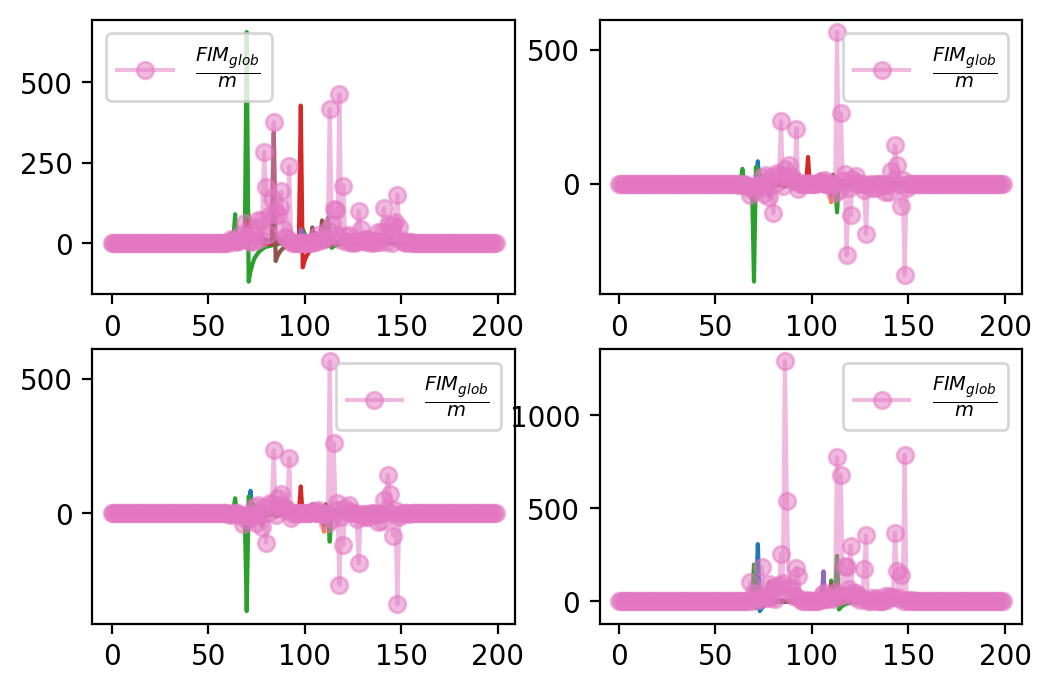

In [97]:
fig,axes = plt.subplots(2,2,dpi=200)

for name,F in log['FIM_est'].items():
    for i in range(2):
        for j in range(2):
            if name=='FIM Glob':
                l = axes[i,j].plot(np.array(F)[:,i,j],label=name,marker = 'o',alpha=0.5)
                axes[i,j].legend(l,[r'$\frac{FIM_{glob}}{m}$'])
            else:
                l = axes[i,j].plot(np.array(F)[:,i,j],label=name)
                

# ax2.legend()

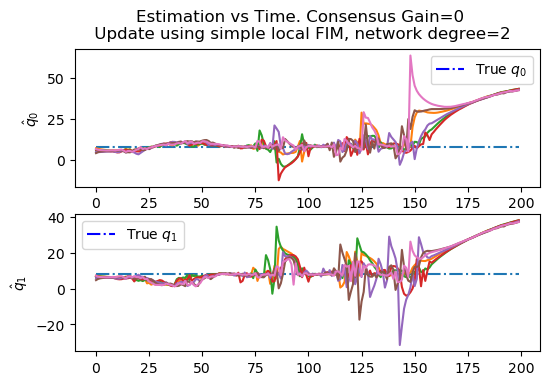

In [98]:
from matplotlib.lines import Line2D

record = log

title=r"Consensus Gain={}".format(0)

qs = record['src_locs']['source_1']

fig, ax = plt.subplots(2,dpi=100)

fig.suptitle('Estimation vs Time. Consensus Gain={}\n Update using simple local FIM, network degree=2'.format(0))
for _ in range(2):
    ax[_].plot(qs[:,_],'-.')
    custom_lines = [Line2D([0], [0], color='blue', ls='-.'),]
    ax[_].legend(custom_lines, ['True $q_{}$'.format(_)])
    for name,est in record['est_locs_log'].items():
        ax[_].plot(est[:,_])
        ax[_].set_ylabel(r'$\hat q_{}$'.format(_))



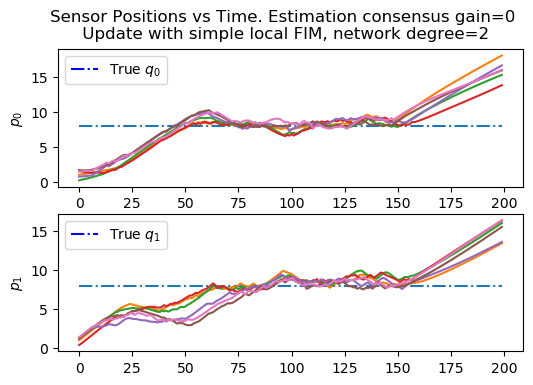

In [99]:

qs = record['src_locs']['source_1']
ps = np.array([locs for sensor, locs in record['sensor_locs'].items()])


fig, ax = plt.subplots(2,dpi=100)

fig.suptitle('Sensor Positions vs Time. Estimation consensus gain={}\n Update with simple local FIM, network degree={}'.format(0,2))
for _ in range(2):
    ax[_].plot(qs[:,_],'-.')
    custom_lines = [Line2D([0], [0], color='blue', ls='-.'),]
    ax[_].legend(custom_lines, ['True $q_{}$'.format(_)])
    for i in range(ps.shape[0]):
        ax[_].plot(ps[i,:,_])
        ax[_].set_ylabel(r'$p_{}$'.format(_))

